固定结果目录为： /Users/along/Documents/Academic/Projects/SHS_ViT/Job_sub/SS_GCNN/results


/var/folders/_2/9y8_tvq51x76mq91wy47h4lw0000gn/T/ipykernel_11010/4268357983.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return cm.get_cmap('tab20', n_colors)


L=4的能量曲线图保存至: energy_plot_L4.png
L=4，已根据y轴范围(-0.85到-0.725)自动调整x轴范围为: 110 - 999
L=4的稳定能量曲线图保存至: energy_plot_L4_stable.png


/var/folders/_2/9y8_tvq51x76mq91wy47h4lw0000gn/T/ipykernel_11010/4268357983.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return cm.get_cmap('tab10', n_colors)


L=5的能量曲线图保存至: energy_plot_L5.png
L=5，已根据y轴范围(-0.85到-0.725)自动调整x轴范围为: 167 - 999
L=5的稳定能量曲线图保存至: energy_plot_L5_stable.png
所有L值的能量曲线汇总图保存至: energy_plot_all.png
汇总图已根据y轴范围(-0.85到-0.725)自动调整x轴范围为: 110 - 999
所有L值的稳定能量曲线汇总图保存至: energy_plot_all_stable.png


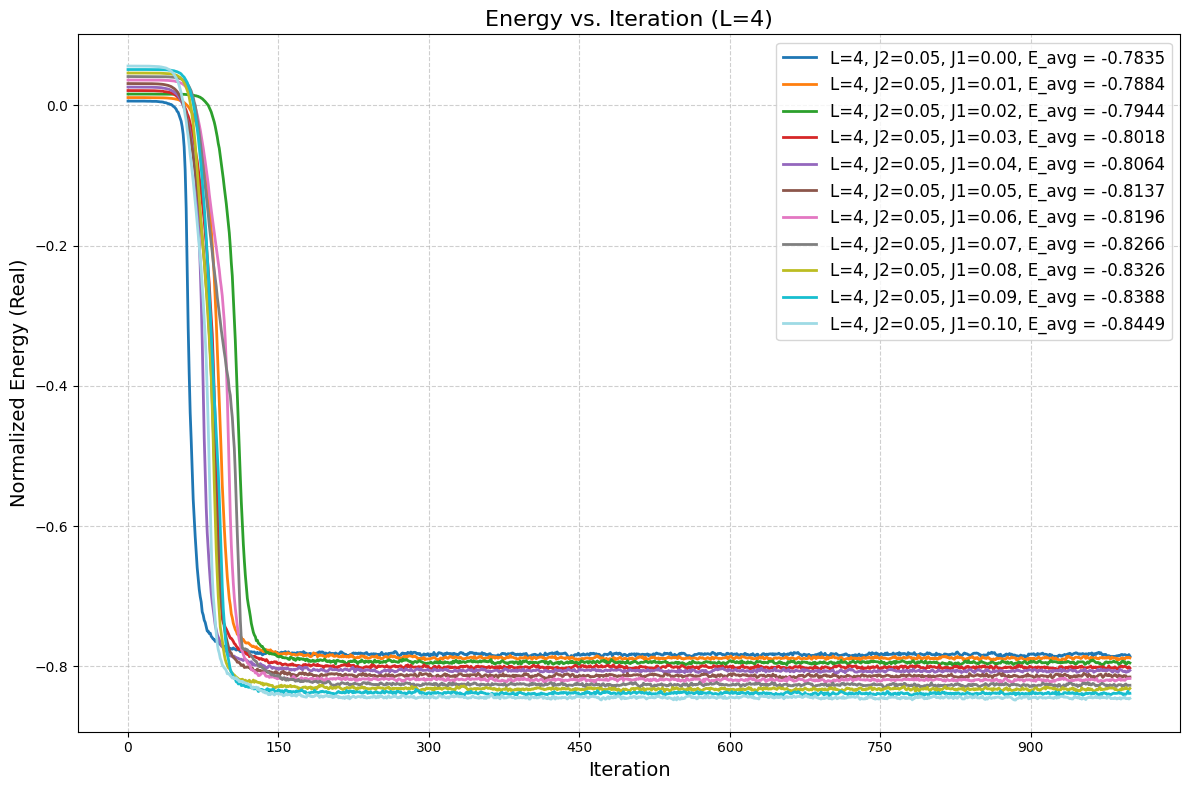

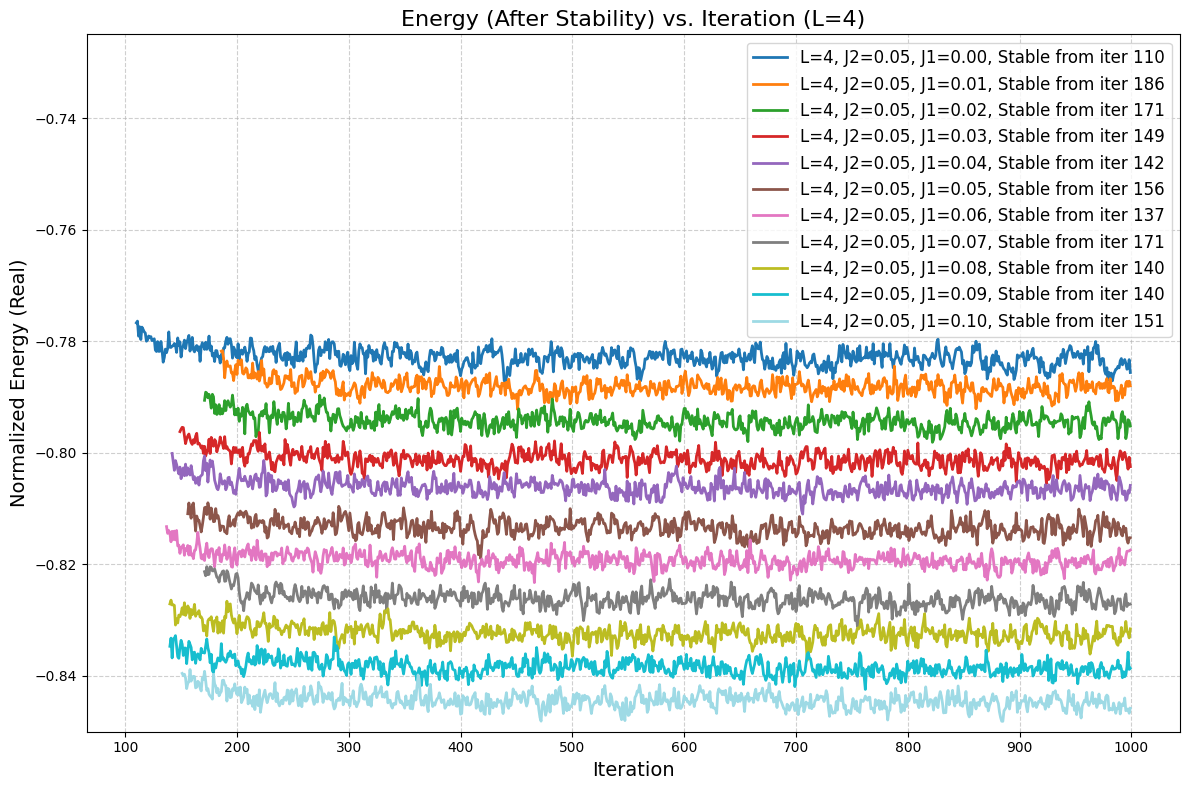

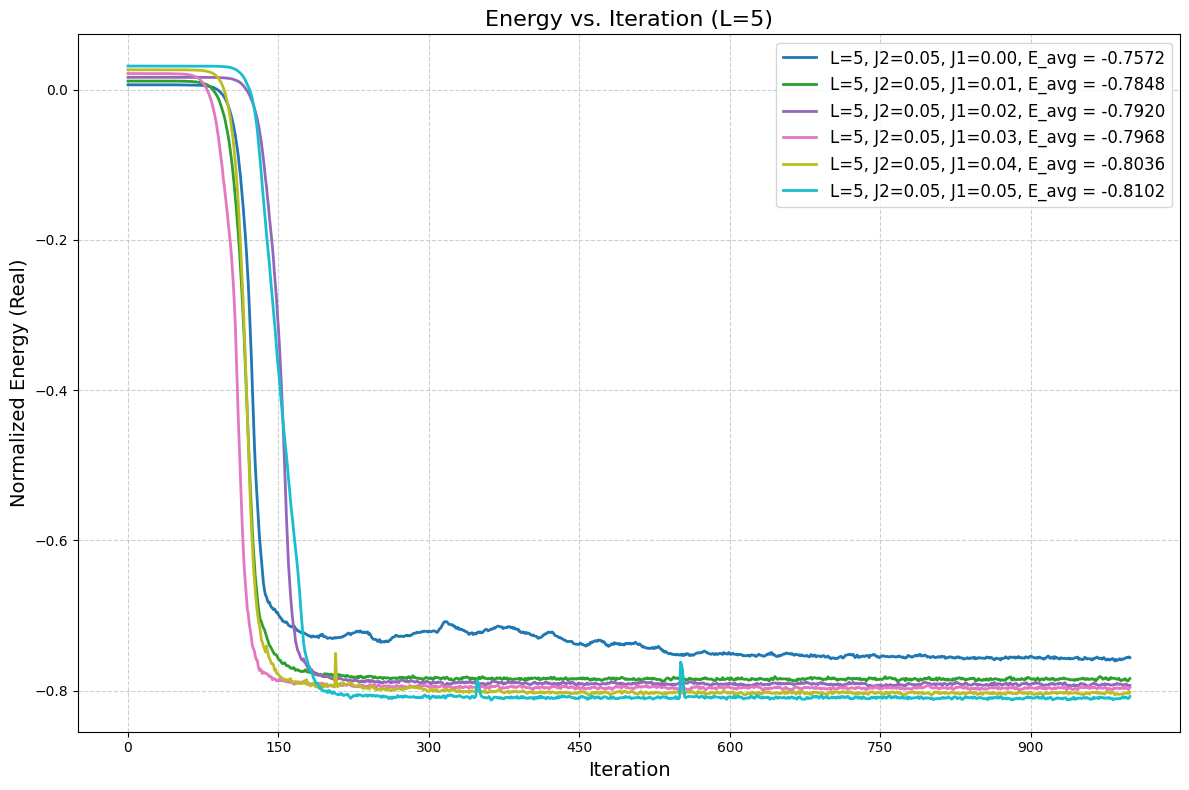

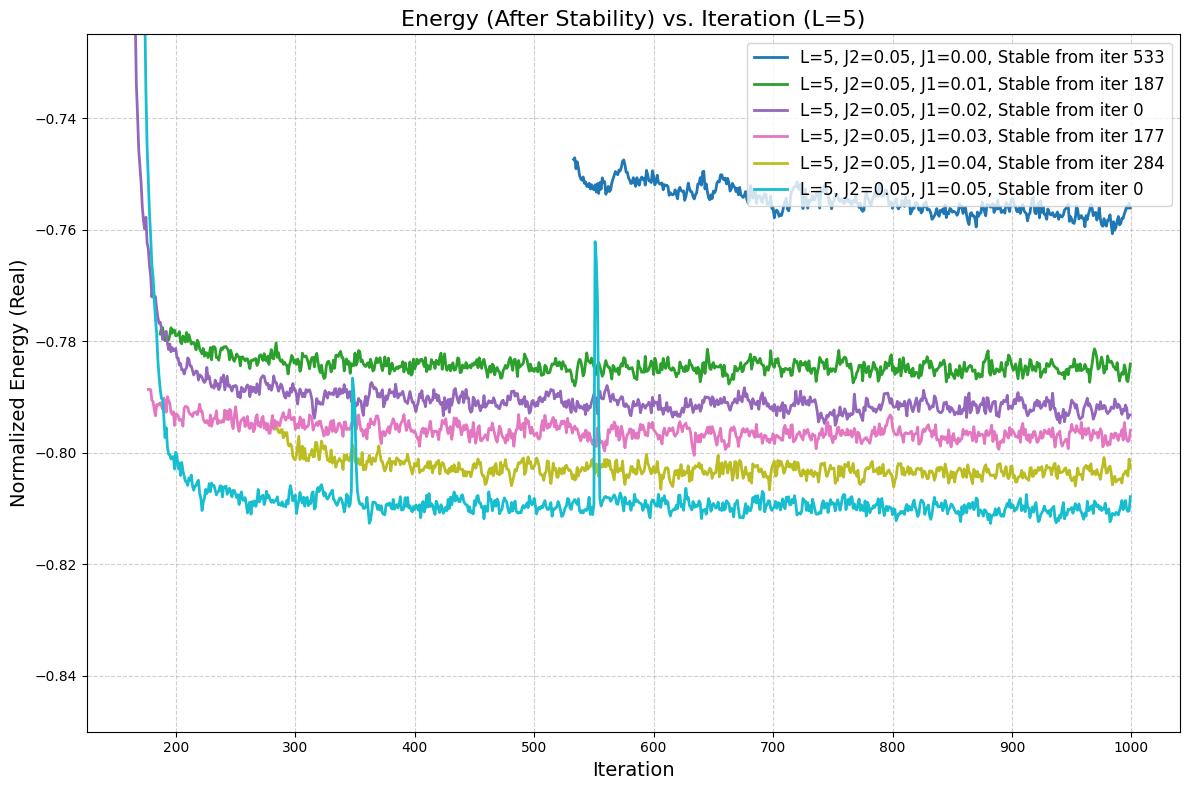

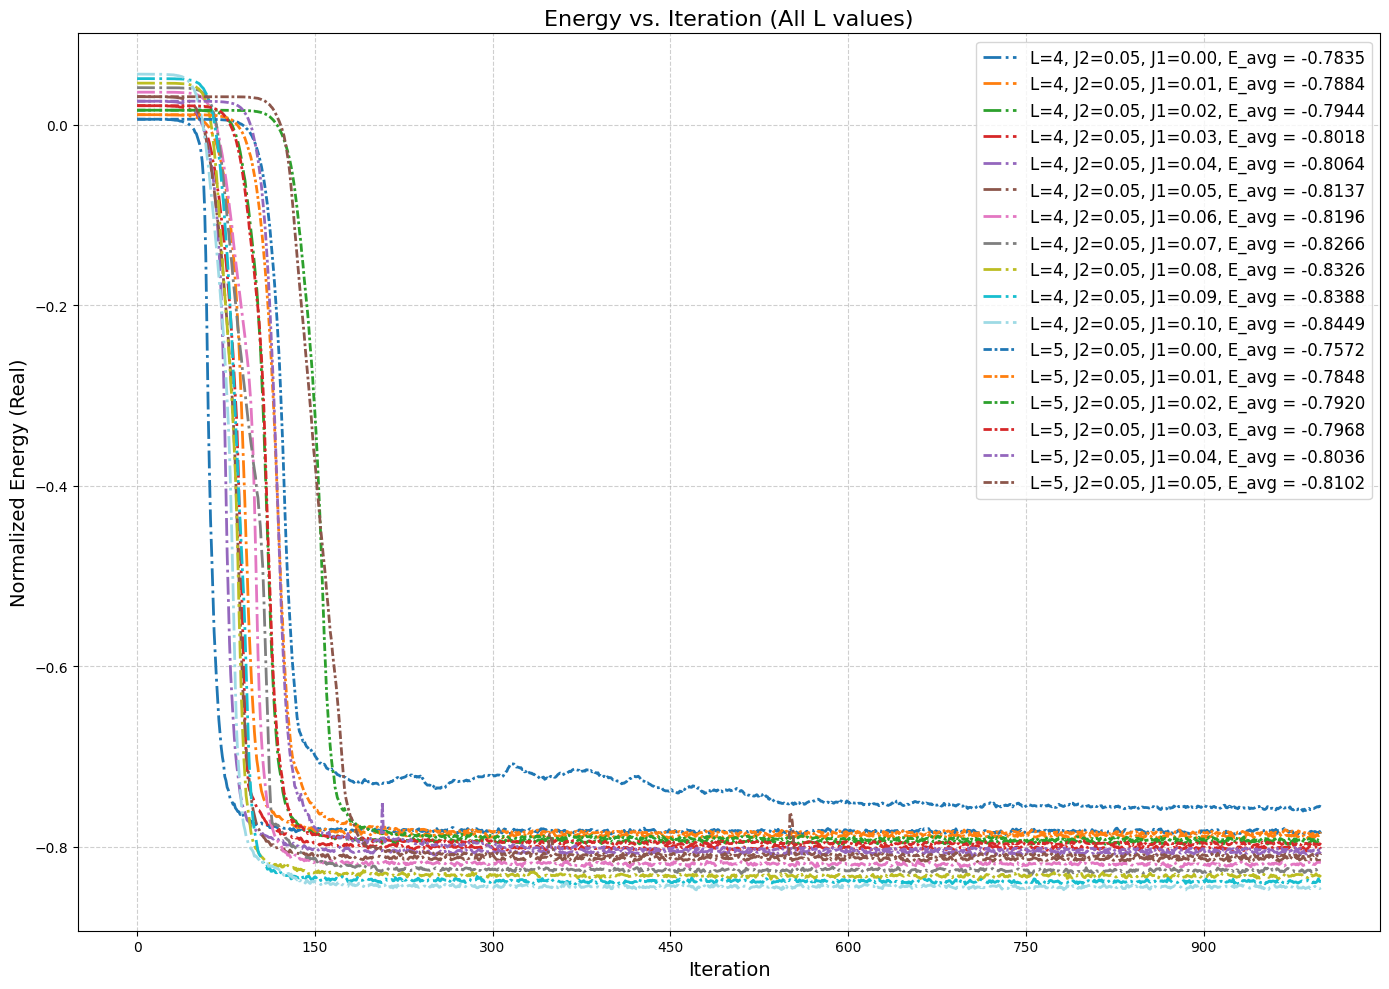

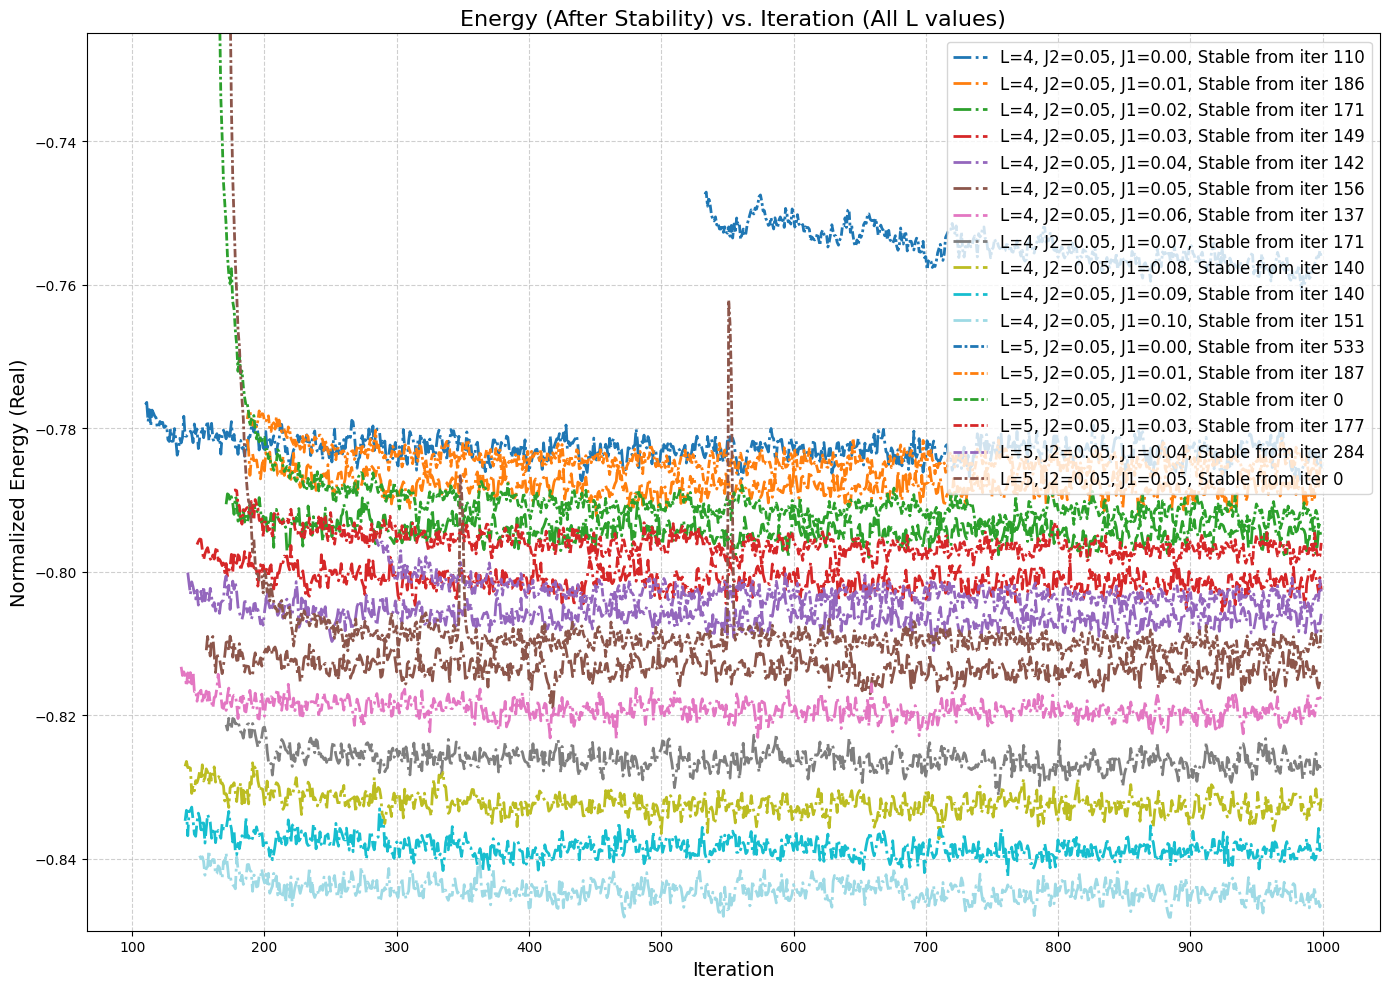

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from itertools import cycle

# 固定 base_dir 为上层目录下的 "results"
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
base_dir = os.path.join(parent_dir, "results")
print("固定结果目录为：", base_dir)

def parse_energy_log(file_path):
    """
    解析指定 energy log 文件，提取迭代步数和能量（复数形式）
    """
    iterations = []
    energies = []
    
    pattern = (r"Iteration:\s*(\d+)/\d+,\s*Temp:\s*([+-]?\d+(?:\.\d+)?),\s*Energy:\s*"
               r"([+-]?\d+(?:\.\d+)?)([+-]\d+(?:\.\d+)?)j")
    
    try:
        with open(file_path, 'r') as f:
            content = f.read()
    except Exception as e:
        print(f"读取文件 {file_path} 出错：{e}")
        return None, None

    for match in re.finditer(pattern, content):
        try:
            iter_num = int(match.group(1))
            energy_real = float(match.group(3))
            energy_imag = float(match.group(4))
            energy = complex(energy_real, energy_imag)
            
            iterations.append(iter_num)
            energies.append(energy)
        except ValueError as ve:
            print(f"解析文件 {file_path} 时出错：{ve}")
            continue
    
    return iterations, energies

def extract_params_from_path(file_path):
    """
    从文件路径中提取参数 L, J1, J2，并返回包含这些参数的字典
    """
    parts = os.path.normpath(file_path).split(os.sep)
    params = {}
    
    for part in parts:
        # 检查是否含有形如 L=4, J1=0.03, J2=0.05 的参数
        for param_prefix in ["L=", "J1=", "J2="]:
            if part.startswith(param_prefix):
                param_name = param_prefix.strip("=")
                param_value = part[len(param_prefix):]
                try:
                    # 将值转换为数值类型
                    params[param_name] = (
                        int(param_value) if param_value.isdigit() else 
                        float(param_value)
                    )
                except ValueError:
                    params[param_name] = param_value
    
    return params

def extract_label_from_path(file_path, base_dir):
    """
    根据日志文件路径中的目录信息生成标签，按 L, J2, J1 顺序构建
    """
    params = extract_params_from_path(file_path)
    
    # 按 L, J2, J1 的顺序构建标签
    ordered_params = []
    for param_name in ["L", "J2", "J1"]:
        if param_name in params:
            value = params[param_name]
            # 整数不显示小数点，浮点数保留2位小数
            if isinstance(value, int):
                ordered_params.append(f"{param_name}={value}")
            else:
                ordered_params.append(f"{param_name}={value:.2f}")
    
    label = ", ".join(ordered_params) if ordered_params else os.path.basename(file_path)
    return label

def extract_L_from_params(params):
    """
    从参数字典中提取L值
    """
    return params.get("L", None)

def extract_J_params(params):
    """
    从参数字典中提取(J2, J1)组合作为元组
    """
    j2 = params.get("J2", None)
    j1 = params.get("J1", None)
    if j2 is not None and j1 is not None:
        return (j2, j1)
    return None

def get_stable_start_index(data, window_size=10, stable_threshold=0.001):
    """
    对数据采用滑动窗口判断能量稳定性
    """
    n = len(data)
    if n < window_size:
        return None
    for i in range(n - window_size + 1):
        window = data[i:i+window_size]
        if max(window) - min(window) < stable_threshold:
            return i
    return None

def create_distinct_colormap(n_colors):
    """
    创建一个颜色分布广泛的颜色映射
    """
    if n_colors <= 10:
        return cm.get_cmap('tab10', n_colors)
    elif n_colors <= 20:
        return cm.get_cmap('tab20', n_colors)
    else:
        return cm.get_cmap('hsv', n_colors)

def get_param_value(curve_data, param_name):
    """
    从曲线标签中提取指定参数的值，用于排序
    """
    _, _, label = curve_data
    pattern = rf"{param_name}=(\d+(?:\.\d+)?)"
    match = re.search(pattern, label)
    if match:
        value = match.group(1)
        return int(value) if value.isdigit() else float(value)
    return float('inf')

def sort_curves_by_params(curves):
    """
    对曲线按L、J2、J1的值从小到大排序
    """
    return sorted(curves, key=lambda x: (
        get_param_value(x, "L"), 
        get_param_value(x, "J2"), 
        get_param_value(x, "J1")
    ))

def extract_unique_j_combinations(all_curves):
    """
    从所有曲线中提取唯一的(J2, J1)组合
    返回：
    - j_combs: 排序后的(J2, J1)组合列表
    - j_comb_to_color: (J2, J1)组合到颜色的映射
    """
    j_combs = set()
    
    for _, _, _, params in all_curves:
        j_comb = extract_J_params(params)
        if j_comb is not None:
            j_combs.add(j_comb)
    
    # 按J2、J1的值从小到大排序
    j_combs = sorted(j_combs)
    
    # 为每个(J2, J1)组合分配一个颜色
    cmap = create_distinct_colormap(len(j_combs))
    j_comb_to_color = {j_comb: cmap(i) for i, j_comb in enumerate(j_combs)}
    
    return j_combs, j_comb_to_color

def scan_and_plot_all_energy_logs(output_prefix="energy_plot", show_plot=True, 
                                 y_min=None, y_max=None, auto_adjust_x=False):
    """
    扫描固定 base_dir 目录下所有 energy log 文件，并按L值分组绘制图表
    
    参数：
      output_prefix: 输出文件名前缀
      show_plot: 是否显示图像
      y_min: 第二幅图y轴的最小值，若为None则自动设置
      y_max: 第二幅图y轴的最大值，若为None则自动设置
      auto_adjust_x: 是否根据y轴范围自动调整x轴范围
    """
    all_curves = []  # 所有曲线数据，格式为 (iterations, normalized_energies, base_label, params_dict)
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            # 文件名必须包含 "energy_" 且以 ".log" 结尾
            if "energy_" in file and file.endswith(".log"):
                file_path = os.path.join(root, file)
                iterations, energies = parse_energy_log(file_path)
                if iterations and energies:
                    params = extract_params_from_path(file_path)
                    base_label = extract_label_from_path(file_path, base_dir)
                    
                    # 获取L值，若无L值则不进行归一化
                    L_val = params.get("L")
                    if L_val:
                        norm_factor = 4 * (L_val ** 2)
                    else:
                        norm_factor = 1
                        
                    # 归一化能量：仅取实部
                    normalized_energies = [e.real / norm_factor for e in energies]
                    all_curves.append((iterations, normalized_energies, base_label, params))
    
    if not all_curves:
        print("未找到任何 energy log 文件。")
        return None

    # 提取所有唯一的(J2, J1)组合
    _, j_comb_to_color = extract_unique_j_combinations(all_curves)

    # 将曲线按L值分组
    L_curves = {}
    for curve in all_curves:
        iterations, normalized_energies, base_label, params = curve
        L_val = params.get("L")
        if L_val is not None:  # 只处理有明确L值的曲线
            if L_val not in L_curves:
                L_curves[L_val] = []
            L_curves[L_val].append((iterations, normalized_energies, base_label, params))
    
    # 为每个L值单独绘制图表
    for L_val, curves in sorted(L_curves.items()):
        # 去除params，保持之前函数的参数格式
        curves_no_params = [(it, en, label) for it, en, label, _ in curves]
        
        # 对当前L值的曲线按J2、J1排序
        curves_no_params = sort_curves_by_params(curves_no_params)
        
        # 参数设定，用于稳定性判断
        stable_threshold = 0.008
        window_size = 100
        
        # 创建颜色映射
        cmap = create_distinct_colormap(len(curves_no_params))
        colors = [cmap(i) for i in range(len(curves_no_params))]
        
        # 第一幅图：所有曲线完整图
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        
        # 记录稳定的曲线数据
        stable_curves = []
        
        for i, (iterations, norm_energies, base_label) in enumerate(curves_no_params):
            # 判断稳定性
            n_points = len(norm_energies)
            n_stable = window_size if n_points >= window_size else n_points
            window_data = norm_energies[-n_stable:]
            window_range = max(window_data) - min(window_data)
            
            stable_idx = get_stable_start_index(norm_energies, window_size, stable_threshold)
            
            if window_range < stable_threshold and stable_idx is not None:
                stable_avg = np.mean(window_data)
                new_label = f"{base_label}, E_avg = {stable_avg:.4f}"
                # 保存稳定数据
                stable_iterations = iterations[stable_idx:]
                stable_energies = norm_energies[stable_idx:]
                stable_label = f"{base_label}, Stable from iter {iterations[stable_idx]}"
                stable_curves.append((stable_iterations, stable_energies, stable_label))
            else:
                new_label = f"{base_label}, Not stable"
            
            ax.plot(iterations, norm_energies, linewidth=2, label=new_label, color=colors[i % len(colors)])
        
        # 设置第一幅图的属性
        ax.set_xlabel("Iteration", fontsize=14)
        ax.set_ylabel("Normalized Energy (Real)", fontsize=14)
        ax.set_title(f"Energy vs. Iteration (L={L_val})", fontsize=16)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(fontsize=12, loc="upper right")
        plt.tight_layout()
        
        # 保存第一幅图
        output_file = f"{output_prefix}_L{L_val}.png"
        plt.savefig(output_file, dpi=300)
        print(f"L={L_val}的能量曲线图保存至: {output_file}")
        
        # 第二幅图：稳定曲线图
        if stable_curves:
            # 对稳定曲线按J2、J1排序
            stable_curves = sort_curves_by_params(stable_curves)
            
            # 创建新的颜色映射
            stable_cmap = create_distinct_colormap(len(stable_curves))
            stable_colors = [stable_cmap(i) for i in range(len(stable_curves))]
            
            plt.figure(figsize=(12, 8))
            ax2 = plt.gca()
            
            for i, (stable_iterations, stable_energies, stable_label) in enumerate(stable_curves):
                ax2.plot(stable_iterations, stable_energies, linewidth=2, 
                       label=stable_label, color=stable_colors[i % len(stable_colors)])
            
            # 设置y轴范围
            if y_min is not None or y_max is not None:
                ax2.set_ylim(bottom=y_min, top=y_max)
                
                # 自动调整x轴范围
                if auto_adjust_x and y_min is not None and y_max is not None:
                    x_points = []
                    
                    for (stable_iterations, stable_energies, _) in stable_curves:
                        for i, energy in enumerate(stable_energies):
                            if y_min <= energy <= y_max:
                                x_points.append(stable_iterations[i])
                    
                    if x_points:
                        x_min = min(x_points)
                        x_max = max(x_points)
                        x_padding = (x_max - x_min) * 0.05 if x_max > x_min else x_max * 0.05
                        ax2.set_xlim(x_min - x_padding, x_max + x_padding)
                        print(f"L={L_val}，已根据y轴范围({y_min}到{y_max})自动调整x轴范围为: {x_min} - {x_max}")
                    else:
                        print(f"L={L_val}，在指定y轴范围内未找到数据点，x轴将使用默认范围")
            
            # 设置第二幅图的属性        
            ax2.set_title(f"Energy (After Stability) vs. Iteration (L={L_val})", fontsize=16)
            ax2.set_xlabel("Iteration", fontsize=14)
            ax2.set_ylabel("Normalized Energy (Real)", fontsize=14)
            ax2.grid(True, linestyle="--", alpha=0.6)
            ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.legend(fontsize=12, loc="upper right")
            plt.tight_layout()
            
            # 保存第二幅图
            stable_output_file = f"{output_prefix}_L{L_val}_stable.png"
            plt.savefig(stable_output_file, dpi=300)
            print(f"L={L_val}的稳定能量曲线图保存至: {stable_output_file}")
        else:
            print(f"L={L_val}没有找到稳定的能量曲线。")
    
    # 绘制汇总图（包含所有L值）
    if all_curves:
        plot_summary_figure_with_same_j_colors(all_curves, output_prefix, j_comb_to_color, 
                                             stable_threshold, window_size,
                                             y_min, y_max, auto_adjust_x, show_plot)
    
    if show_plot:
        plt.show()
    else:
        plt.close('all')

def plot_summary_figure_with_same_j_colors(all_curves, output_prefix, j_comb_to_color, 
                                         stable_threshold, window_size,
                                         y_min=None, y_max=None, auto_adjust_x=False, show_plot=True):
    """
    绘制包含所有L值的汇总图，对于具有相同J2、J1值的曲线使用相同颜色，使用不同线型区分L值
    """
    # 不同L值使用不同的线型
    line_styles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (3, 5, 1, 5))]
    
    # 对所有曲线按L、J2、J1排序
    sorted_curves = sorted(all_curves, key=lambda x: (
        x[3].get("L", float('inf')), 
        x[3].get("J2", float('inf')), 
        x[3].get("J1", float('inf'))
    ))
    
    # 第一幅图：所有L值的完整曲线
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    
    stable_curves = []
    
    for i, (iterations, norm_energies, base_label, params) in enumerate(sorted_curves):
        # 获取L值和(J2, J1)组合
        L_val = params.get("L")
        j_comb = extract_J_params(params)
        
        # 判断稳定性
        n_points = len(norm_energies)
        n_stable = window_size if n_points >= window_size else n_points
        window_data = norm_energies[-n_stable:]
        window_range = max(window_data) - min(window_data)
        
        stable_idx = get_stable_start_index(norm_energies, window_size, stable_threshold)
        
        if window_range < stable_threshold and stable_idx is not None:
            stable_avg = np.mean(window_data)
            new_label = f"{base_label}, E_avg = {stable_avg:.4f}"
            # 保存稳定数据
            stable_iterations = iterations[stable_idx:]
            stable_energies = norm_energies[stable_idx:]
            stable_label = f"{base_label}, Stable from iter {iterations[stable_idx]}"
            stable_curves.append((stable_iterations, stable_energies, stable_label, params))
        else:
            new_label = f"{base_label}, Not stable"
        
        # 根据L值选择线型，根据(J2, J1)选择颜色
        if L_val is not None and j_comb is not None and j_comb in j_comb_to_color:
            line_style = line_styles[(L_val - 1) % len(line_styles)]  # 假设L值从1开始
            color = j_comb_to_color[j_comb]
            ax.plot(iterations, norm_energies, linestyle=line_style, linewidth=2, 
                   label=new_label, color=color)
        else:
            # 如果没有找到特定参数，使用默认样式
            ax.plot(iterations, norm_energies, linewidth=2, label=new_label)
    
    # 设置第一幅图属性
    ax.set_xlabel("Iteration", fontsize=14)
    ax.set_ylabel("Normalized Energy (Real)", fontsize=14)
    ax.set_title("Energy vs. Iteration (All L values)", fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(fontsize=12, loc="upper right")
    plt.tight_layout()
    
    # 保存汇总图
    summary_output_file = f"{output_prefix}_all.png"
    plt.savefig(summary_output_file, dpi=300)
    print(f"所有L值的能量曲线汇总图保存至: {summary_output_file}")
    
    # 绘制所有稳定曲线的汇总图
    if stable_curves:
        # 对稳定曲线按L、J2、J1排序
        stable_curves = sorted(stable_curves, key=lambda x: (
            x[3].get("L", float('inf')), 
            x[3].get("J2", float('inf')), 
            x[3].get("J1", float('inf'))
        ))
        
        plt.figure(figsize=(14, 10))
        ax2 = plt.gca()
        
        for (stable_iterations, stable_energies, stable_label, params) in stable_curves:
            # 获取L值和(J2, J1)组合
            L_val = params.get("L")
            j_comb = extract_J_params(params)
            
            # 根据L值选择线型，根据(J2, J1)选择颜色
            if L_val is not None and j_comb is not None and j_comb in j_comb_to_color:
                line_style = line_styles[(L_val - 1) % len(line_styles)]  # 假设L值从1开始
                color = j_comb_to_color[j_comb]
                ax2.plot(stable_iterations, stable_energies, linestyle=line_style, 
                       linewidth=2, label=stable_label, color=color)
            else:
                # 如果没有找到特定参数，使用默认样式
                ax2.plot(stable_iterations, stable_energies, linewidth=2, label=stable_label)
        
        # 设置y轴范围
        if y_min is not None or y_max is not None:
            ax2.set_ylim(bottom=y_min, top=y_max)
            
            # 自动调整x轴范围
            if auto_adjust_x and y_min is not None and y_max is not None:
                x_points = []
                
                for (stable_iterations, stable_energies, _, _) in stable_curves:
                    for i, energy in enumerate(stable_energies):
                        if y_min <= energy <= y_max:
                            x_points.append(stable_iterations[i])
                
                if x_points:
                    x_min = min(x_points)
                    x_max = max(x_points)
                    x_padding = (x_max - x_min) * 0.05 if x_max > x_min else x_max * 0.05
                    ax2.set_xlim(x_min - x_padding, x_max + x_padding)
                    print(f"汇总图已根据y轴范围({y_min}到{y_max})自动调整x轴范围为: {x_min} - {x_max}")
                else:
                    print(f"汇总图在指定y轴范围内未找到数据点，x轴将使用默认范围")
        
        # 设置第二幅图的属性
        ax2.set_title("Energy (After Stability) vs. Iteration (All L values)", fontsize=16)
        ax2.set_xlabel("Iteration", fontsize=14)
        ax2.set_ylabel("Normalized Energy (Real)", fontsize=14)
        ax2.grid(True, linestyle="--", alpha=0.6)
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.legend(fontsize=12, loc="upper right")
        plt.tight_layout()
        
        # 保存稳定曲线汇总图
        stable_summary_output_file = f"{output_prefix}_all_stable.png"
        plt.savefig(stable_summary_output_file, dpi=300)
        print(f"所有L值的稳定能量曲线汇总图保存至: {stable_summary_output_file}")
    else:
        print("所有曲线中没有找到稳定的能量曲线。")

if __name__ == "__main__":
    # 按L值分别绘制图表
    scan_and_plot_all_energy_logs(
        output_prefix="energy_plot",  # 输出文件名前缀
        show_plot=True,
        y_min=-0.85,  # 可以根据需要调整y轴范围
        y_max=-0.725,
        auto_adjust_x=True  # 启用自动调整x轴范围
    )
